In [5]:
#***********************************#
#                                   #
#             Packages              #        
#                                   #
#***********************************#
import dsp_py as dsp
from scipy import signal as sig 
import csv
import allantools as allan
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import allantools as AT

In [6]:
#***********************************#
#                                   #
#             Constants             #        
#                                   #
#***********************************#

adc_clk = 512 * 10 ** 6 # adc clock rate

T_adc = 1/(adc_clk) # adc period

fpga_clk = 256 * 10 ** 6 # fpga fabric clock rate

FFT_length = 1024 # Length of FFT used in spectrometer

accum_len = 2 ** 23 # number of clock cycles of accumulation in every dump of data

accum_time = ((adc_clk)/FFT_length)/accum_len # amount of time one accumulation cycle integrates (seconds)



# Put parameters for testing here

source_freq = 100 * 10 ** 6 
square_freq = 2


In [7]:
#***********************************#
#                                   #
#            Functions              #        
#                                   #
#***********************************#

def real_wave(amp, freq, time, phase=0):
    omega = 2 * np.pi * freq    
    wave = amp*np.cos(omega * time + phase)
    return wave

def real_mix(wave_1, wave_2):
    mix_wave = wave_1 * wave_2
    return mix_wave
    
def fft(signal):
    spectrum = np.fft.fft(signal, n = FFT_length)
    return spectrum

def noisify(signal):
    w_noise = np.random.normal(0, .1, signal.shape)
    noisy_spec = signal * w_noise
    return noisy_spec

def GET_TO_DA_CHOPPAH(signal, timespace):
    sq_wave = 0.5 * (sig.square(2 * np.pi * square_freq * timespace) + 1)
    chopped_wave = real_mix(signal, sq_wave)
    return chopped_wave

def save_data(file_name, data):
    file = open(file_name, 'w')
    writer = csv.writer(file)
    writer.writerow(data)
    
def allan_var(timestream, res=30):
    rate = 1/(accum_time)
    tau = np.logspace(0, run_time/5, res)
    (tau2, adevs, adev_err, n) = AT.oadev(timestream, rate, data_type="freq", taus=tau)
    avars = np.square(adevs)
    white_line = (avars[0]*(tau2**-1))
    return avars, white_line, adev_err, tau2

In [8]:
#***********************************#
#                                   #
#           Make FFT Frames         #        
#                                   #
#***********************************#

    ##### for a 1024 pt FFT, one FFT frame will take 1024/adc_clk (seconds) ##### 

    # frame time = Time for 1 FFT to populate
frame_time = FFT_length / (adc_clk)

    # frame_freq = how many FFT frames are created in one second
frame_freq = adc_clk/FFT_length

    #The number of fft frames to be created equals the run time of the test over the amount of time it takes to FFT a frame                        #

    # accum_frames = number of FFT frames created over one accumulation
accum_frames = int(accum_time/frame_time)

    # Now create array which contains frequency span of FFT in order to have correctly scaled FFT plots
timestep = 1/adc_clk
    
    # note this value comes from the linspace used for the time array. length/number of samples
    # this array will be used to properly map the x-axis in Fourier space plots
fft_freq = np.fft.fftfreq(FFT_length, d=timestep)


In [5]:
## Simulating the hoh_spec firmware ##

def hoh_spec(chan, run_time):
        
        # Define how many seconds of data should be simulated and how many accumulations are required
    
    num_accum = int(run_time * (1/accum_time)) # number of total accumulations in simulation time
    
        # create file name for saving data in csv if desired
        
    file_name = '%d_sec_hohspec_sim_chan_%d.csv'%(run_time, chan)    
    
        #Make an empty array to be filled with accumulations
        
    accums = np.zeros(num_accum)
    
    #***********************************#
    #                                   #
    #           Creating Time           #        
    #                                   #
    #***********************************#
    
    for i in range(num_accum-1):
        print('we are on accumulation number %d out of %d'%(i, num_accum))
        
        frame_times = np.zeros(accum_frames)

            ##### Create an array with the times of the FFT frames #####

        for j in range(accum_frames):                                 
            
            frame_times[j] = (i * frame_time) + j * frame_time

            ##### Create an array of times that will be used to create the "pieces" of the wave #####

        timespace = np.zeros((accum_frames-1, FFT_length))

            ##### Populate time array with lengths to be used later #####

        for j in range(accum_frames-1):

            timespace[j] = np.linspace(frame_times[j], frame_times[j+1], FFT_length)     
            
    #***********************************#
    #                                   #
    #            White noise            #
    #   (Creation and Timestreaming)    #
    #                                   #
    #***********************************#

            # create empty array to hold white noise signal
        
        signal = np.zeros(np.shape(timespace))
            
            # create white noise equivalent to what is used in tests
            
        for j in range(accum_frames-1):
            signal[j] = allan.noise.white(FFT_length, 0.1, adc_clk) #create large array of white noise

            # Now put the noise signal through PFB
        
        spectra = fft(signal)

            # To get timestreams, convert from rows of freq and columns of time to rows of time streams and columns of freq
            # I'm pretty proud of how cheeky this trick is tbh, all you need is a transpose, no array slicing and dicing
            
        t_streams = np.transpose(spectra)

            # Now take the intensity of each of the time streams

        t_mags = np.square(np.real(t_streams)) + np.square(np.imag(t_streams))
        
            # Now integrate the timestream as is done in firmware
        
        accum = np.sum(t_mags[chan])
            
            # Plop the accumulation data into our accumulation array for further faffing about
        
        accums[i] = accum
    
    return file_name, accums
    

In [6]:
## Simulating the lock in (using modulated white noise data)

def lock_in(chan, run_time, phase=0):
        
        # Define how many seconds of data should be simulated and how many accumulations are required
    
    num_accum = int(run_time * (1/accum_time)) # number of total accumulations in simulation time
    
        # create file name for saving data in csv if desired
        
    file_name = '%d_sec_lockin_sim_chan_%d.csv'%(run_time, chan)    
    
        #Make an empty array to be filled with accumulations
        
    accums = np.zeros(num_accum)
    
    unmix_mags = []
    mix_mags = []
    #***********************************#
    #                                   #
    #           Creating Time           #        
    #                                   #
    #***********************************#
    
    for i in range(num_accum):
        print('we are on accumulation number %d out of %d'%(i, num_accum))
        
        frame_times = np.zeros(accum_frames)

            ##### Create an array with the times of the FFT frames #####

        for j in range(accum_frames):                                 
            
            frame_times[j] = (i * frame_time) + j * frame_time

            ##### Create an array of times that will be used to create the "pieces" of the wave #####

        timespace = np.zeros((accum_frames-1, FFT_length))

            ##### Populate time array with lengths to be used later #####

        for j in range(accum_frames-1):

            timespace[j] = np.linspace(frame_times[j], frame_times[j+1], FFT_length)     
            
    #***********************************#
    #                                   #
    #            Signals                #
    #   (Creation and Timestreaming)    #
    #                                   #
    #***********************************#
               
            # create empty array to hold white noise signal
        
        signal = np.zeros(np.shape(timespace))
            
            # create white noise equivalent to what is used in tests
            
        for j in range(accum_frames-1): signal[j] = allan.noise.white(FFT_length, 0.1, adc_clk) #create array of white noise          
            
            # Chop up white noise at chop frequency (comment next line to get unchopped results)
        
        choppa_signal = GET_TO_DA_CHOPPAH(signal, timespace)

            # Now put the choppeed noise signal through PFB
        
        spectra = fft(signal)

            # To get timestreams, convert from rows of freq and columns of time to rows of time streams and columns of freq
            # I'm pretty proud of how cheeky this trick is tbh, all you need is a transpose, no array slicing and dicing
            
        t_streams = np.transpose(spectra)
        
        chan_stream = t_streams[chan]

            # Now take the intensity of each of the time streams

        t_mags = np.square(np.real(t_streams)) + np.square(np.imag(t_streams))
        
        chan_mag = t_mags[chan]
        
        unmix_mags.append(chan_mag)
        
        #########################################
        #    Mixing Channel Timestreams Down    #
        #########################################   
        
            # Create time array to control internally generated wave 

        timespace2 = np.linspace(0, run_time, accum_frames-1)

            # Create generated signal inside FPGA at square wave frequency 
    
        cordic_wave = real_wave(1, square_freq, timespace2, phase)
        
            # Get intensity of internal wave
            
        cordic_mag = np.square(cordic_wave)
        
            # mix together FFT timestream with internal cordic wave
        
        downmix = real_mix(chan_mag, cordic_mag)
        
        mix_mags.append(downmix)
        
            # Now integrate the timestream as is done in firmware
        
        accum = np.sum(downmix)
            
            # Plop the accumulation data into our accumulation array for further faffing about
        
        accums[i] = accum
    
    return file_name, accums, unmix_mags, mix_mags

In [93]:
# Now make a main script to do all the bullshit

#def main(chan, run_time):

    # necessary variable-constant variables
    
chan = 300
run_time = 1000

    # create data sets for both firmware simulations
(lock_in_file, lock_in_data,unmix,mixes) = lock_in(chan, run_time)    
(hoh_spec_file, hoh_spec_data) = hoh_spec(chan, run_time)


    # take the allan variance measurement for both of them 

#avars_hs, white_line_hs, adev_err_hs = allan_var(hoh_spec_data)
#avars_li, white_line_li, adev_err_li = allan_var(lock_in_data)

we are on accumulation number 0 out of 16777
we are on accumulation number 1 out of 16777
we are on accumulation number 2 out of 16777
we are on accumulation number 3 out of 16777
we are on accumulation number 4 out of 16777
we are on accumulation number 5 out of 16777
we are on accumulation number 6 out of 16777
we are on accumulation number 7 out of 16777
we are on accumulation number 8 out of 16777
we are on accumulation number 9 out of 16777
we are on accumulation number 10 out of 16777
we are on accumulation number 11 out of 16777
we are on accumulation number 12 out of 16777
we are on accumulation number 13 out of 16777
we are on accumulation number 14 out of 16777
we are on accumulation number 15 out of 16777
we are on accumulation number 16 out of 16777
we are on accumulation number 17 out of 16777
we are on accumulation number 18 out of 16777
we are on accumulation number 19 out of 16777
we are on accumulation number 20 out of 16777
we are on accumulation number 21 out of 1677

MemoryError: 

<ErrorbarContainer object of 3 artists>

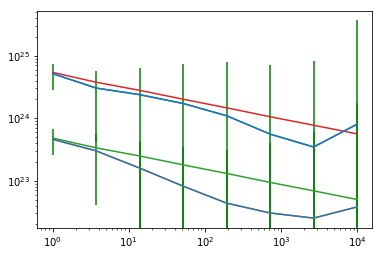

In [48]:
tau = np.logspace(0, run_time/5, 8)
plt.loglog(tau,avars_hs)
plt.loglog(tau, avars_li)
plt.loglog(tau, white_line_li)
plt.loglog(tau, white_line_hs)
plt.errorbar(tau, avars_li, yerr = 2*(avars_li[::]/np.sqrt((run_time/tau[::]))), ecolor='g')
plt.errorbar(tau, avars_hs, yerr = 2*(avars_hs[::]/np.sqrt((run_time/tau[::]))), ecolor='g')

In [82]:
print(lock_in(300,0.125)[1])
print(lock_in(300,0.125)[2])

we are on accumulation number 0 out of 2
we are on accumulation number 1 out of 2
[1.94922249e+14 1.95948227e+14]
we are on accumulation number 0 out of 2
we are on accumulation number 1 out of 2
[3.85889286e+14 3.87698428e+14]


In [64]:
0.25/2

0.125

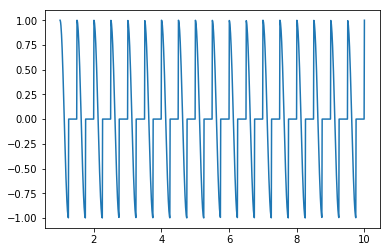

In [91]:
def intensity(wave):
    intense = np.real(wave)**2 + np.imag(wave)**2
    return intense
time = np.linspace(1,10,1024)
fft_freq = np.fft.fftfreq(FFT_length, d=9/1024)
a = np.cos(2*np.pi*5* time)
b = GET_TO_DA_CHOPPAH(a, time)
c = real_wave(1, square_freq, time)
d = b*c
e = np.real(d)**2+np.imag(d)**2
sq_wave = 0.5 * (sig.square(2 * np.pi * square_freq * time) + 1)
f = sq_wave*c
mag = fft(a)
mag = intensity(mag)
#plt.plot(fft_freq, mag)
#plt.plot(time, c)
#plt.plot(time, sq_wave)
plt.plot(time, f)
#plt.plot(time, c)
#plt.plot(time, b)
#plt.xlim(-10,10)

2.0


(0, 6)

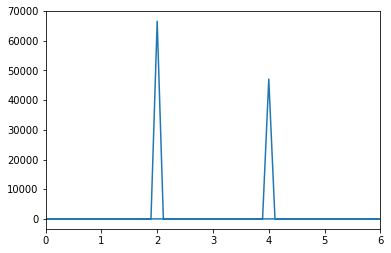

In [92]:
c = real_wave(1, square_freq, time, np.pi/1.5)
d = b*c
e = np.real(d)**2+np.imag(d)**2

sq_wave = 0.5 * (sig.square(2 * np.pi * square_freq * time) + 1)

mag = fft(f)
mag = intensity(mag)
print(fft_freq[list(mag).index(np.max(mag))])
plt.plot(fft_freq, mag)
plt.xlim(0,6)

In [ ]:
def intensity(wave):
    intense = np.real(wave)**2 + np.imag(wave)**2
    return intense
time = np.linspace(1,10,1024)
fft_freq = np.fft.fftfreq(FFT_length, d=9/1024)


mag = fft(a)
mag = intensity(mag)